# Demo 1: Anti-CRISPR 数据表征

参考 BertADP：序列长度分布、20 种氨基酸组成、Top 10 二肽。
数据来源：`anticrispr_benchmarks/anticrispr_binary.train.csv` 与 `.test.csv`。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = '/home/nemophila/projects/protein_bert'
BENCHMARKS_DIR = os.path.join(PROJECT_ROOT, 'anticrispr_benchmarks')

from proteinbert import load_anticrispr_with_ids

train_df, test_df = load_anticrispr_with_ids(BENCHMARKS_DIR, benchmark_name='anticrispr_binary')
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df], ignore_index=True)
df['len'] = df['seq'].str.len()
df['class_name'] = df['label'].map({0: 'Non-Acr', 1: 'Acr'})
print('Train:', len(train_df), 'Test:', len(test_df), 'Acr:', df['label'].sum())

2026-02-20 19:42:51.601956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Train: 1107 Test: 286 Acr: 231


## 1. 序列长度分布

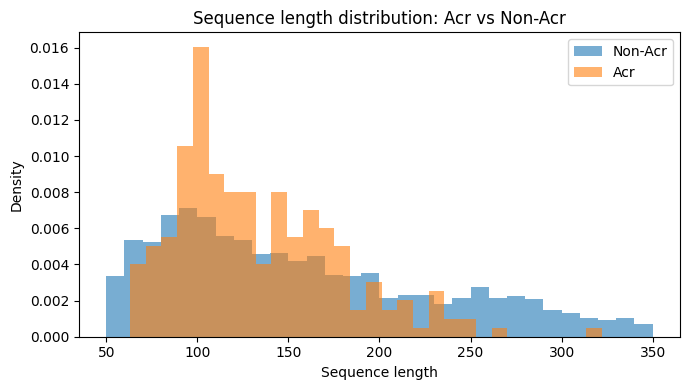

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for label, name in [(0, 'Non-Acr'), (1, 'Acr')]:
    lens = df.loc[df['label'] == label, 'len']
    ax.hist(lens, bins=30, alpha=0.6, label=name, density=True)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Density')
ax.legend()
ax.set_title('Sequence length distribution: Acr vs Non-Acr')
plt.tight_layout()
plt.show()

## 2. 20 种氨基酸组成对比

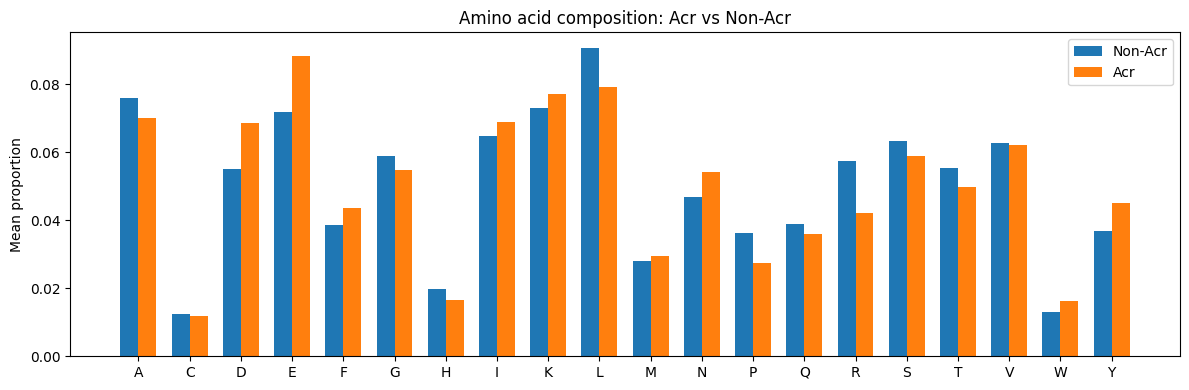

In [3]:
AA = list('ACDEFGHIKLMNPQRSTVWY')

def aa_composition(seq):
    cnt = {a: seq.count(a) for a in AA}
    total = sum(cnt.values()) or 1
    return [cnt[a] / total for a in AA]

comp = df.groupby('label')['seq'].apply(
    lambda s: pd.DataFrame([aa_composition(seq) for seq in s], columns=AA).mean()
).unstack(0)
comp.columns = ['Non-Acr', 'Acr']

x = np.arange(len(AA))
w = 0.35
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x - w/2, comp['Non-Acr'], w, label='Non-Acr')
ax.bar(x + w/2, comp['Acr'], w, label='Acr')
ax.set_xticks(x)
ax.set_xticklabels(AA)
ax.set_ylabel('Mean proportion')
ax.legend()
ax.set_title('Amino acid composition: Acr vs Non-Acr')
plt.tight_layout()
plt.show()

## 3. Top 10 二肽（Acr vs Non-Acr）

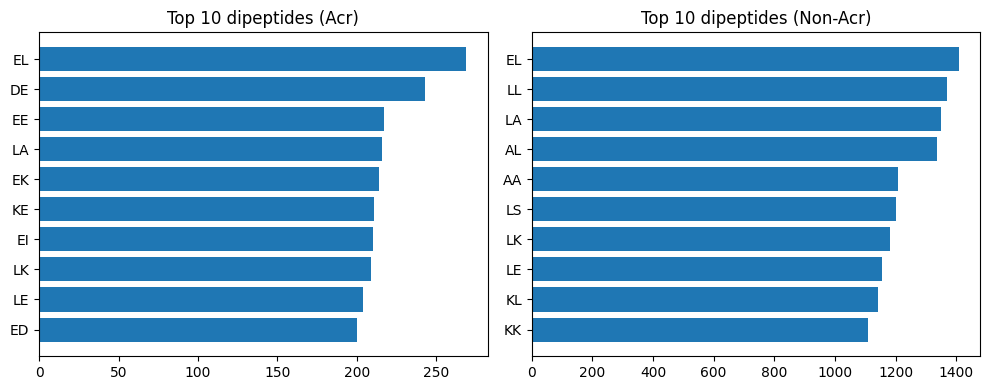

Acr top10: ['EL', 'DE', 'EE', 'LA', 'EK', 'KE', 'EI', 'LK', 'LE', 'ED']
Non-Acr top10: ['EL', 'LL', 'LA', 'AL', 'AA', 'LS', 'LK', 'LE', 'KL', 'KK']


In [4]:
from collections import Counter

def top_dipeptides(seqs, k=10):
    c = Counter()
    for s in seqs:
        for i in range(len(s) - 1):
            c[s[i:i+2]] += 1
    return c.most_common(k)

acr_seqs = df.loc[df['label'] == 1, 'seq']
non_seqs = df.loc[df['label'] == 0, 'seq']
top_acr = top_dipeptides(acr_seqs, 10)
top_non = top_dipeptides(non_seqs, 10)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].barh([x[0] for x in top_acr], [x[1] for x in top_acr])
axes[0].set_title('Top 10 dipeptides (Acr)')
axes[0].invert_yaxis()
axes[1].barh([x[0] for x in top_non], [x[1] for x in top_non])
axes[1].set_title('Top 10 dipeptides (Non-Acr)')
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()
print('Acr top10:', [x[0] for x in top_acr])
print('Non-Acr top10:', [x[0] for x in top_non])